# Import Libraries

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random

C:\Users\sohan\.conda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\sohan\.conda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wan

# Load Dataset

In [2]:
DATADIR = r"C:\Users\sohan\Downloads\Compressed\Training-20231217T141534Z-001\Training"
CATEGORIES = ["bcc","bkl","mel","nv"]
training_data = []
IMG_SIZE=128
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                print(e)

create_training_data()

print(len(training_data))

100%|██████████| 1260/1260 [00:09<00:00, 127.64it/s]

5040


In [5]:
random.shuffle(training_data)
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

[[[[212 214 245]
   [222 224 254]
   [207 216 246]
   ...
   [208 207 246]
   [206 205 245]
   [199 192 237]]

  [[212 212 242]
   [214 216 244]
   [207 215 245]
   ...
   [207 206 245]
   [209 203 244]
   [203 196 236]]

  [[217 218 246]
   [225 225 253]
   [215 222 248]
   ...
   [208 206 243]
   [207 207 244]
   [213 201 247]]

  ...

  [[237 237 254]
   [235 236 250]
   [236 236 254]
   ...
   [201 198 243]
   [204 204 243]
   [205 200 246]]

  [[235 235 249]
   [237 238 252]
   [235 231 247]
   ...
   [210 209 244]
   [206 206 243]
   [202 200 243]]

  [[232 239 252]
   [241 237 251]
   [234 233 249]
   ...
   [204 201 239]
   [203 202 240]
   [203 204 238]]]]


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.33, random_state=42)

In [8]:
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_train shape: {x_val.shape} - y_train shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (3528, 128, 128, 3) - y_train shape: (3528,)
x_train shape: (1013, 128, 128, 3) - y_train shape: (1013,)
x_test shape: (499, 128, 128, 3) - y_test shape: (499,)


In [9]:
input_shape = (128, 128, 3)
num_classes=4

In [10]:
learning_rate = 0.00001
weight_decay = 0.000001
batch_size = 32
num_epochs = 100
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [1024, 512]  # Size of the dense layers of the final classifier

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [12]:
# def scheduler(epoch, lr):
#     if epoch < 30:
#         return lr
#     elif epoch < 60:
#         return lr*0.1
#     else:
#         return lr * 0.01

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            'Patch_size': self.patch_size
        })
        return config

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


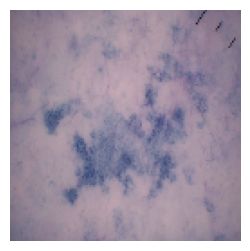

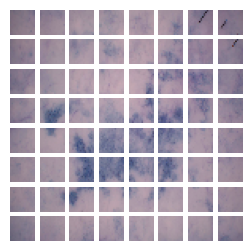

In [15]:
plt.figure(figsize=(3, 3))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(3, 3))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection_dim
        })
        return config

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.1)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )
    checkpoint_filepath = 'model_checkpoint.h5'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',  
        mode='max',              
        save_best_only=True,     
        verbose=1
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback]
    )

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
110/111 [============================>.] - ETA: 0s - loss: 1.3825 - accuracy: 0.3591
Epoch 1: val_accuracy improved from -inf to 0.52221, saving model to model_checkpoint.h5
111/111 [==============================] - 16s 64ms/step - loss: 1.3825 - accuracy: 0.3591 - val_loss: 1.1056 - val_accuracy: 0.5222
Epoch 2/100
111/111 [==============================] - ETA: 0s - loss: 1.1938 - accuracy: 0.4626
Epoch 2: val_accuracy improved from 0.52221 to 0.55874, saving model to model_checkpoint.h5
111/111 [==============================] - 6s 51ms/step - loss: 1.1938 - accuracy: 0.4626 - val_loss: 1.0118 - val_accuracy: 0.5587
Epoch 3/100
110/111 [============================>.] - ETA: 0s - loss: 1.1027 - accuracy: 0.5170
Epoch 3: val_accuracy improved from 0.55874 to 0.58243, saving model to model_checkpoint.h5
111/111 [==============================] - 6s 52ms/step - loss: 1.1019 - accuracy: 0.5173 - val_loss: 0.9619 - val_accuracy: 0.5824
Epoch 4/100
110/111 [==================

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

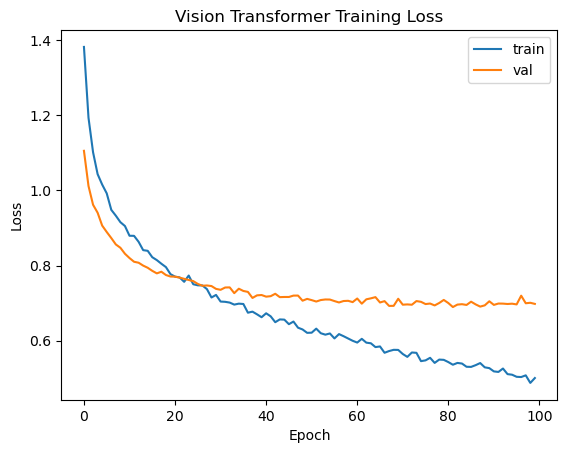

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Vision Transformer Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.show()

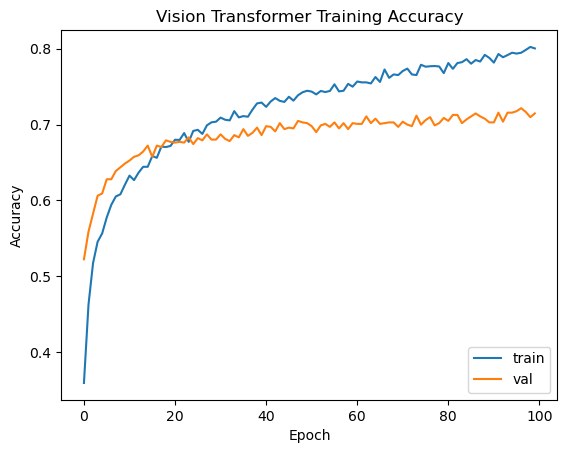

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Vision Transformer Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'lower right')
plt.show()

In [22]:
y_pred = vit_classifier.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

16/16 [==============================] - 1s 27ms/step


<AxesSubplot: >

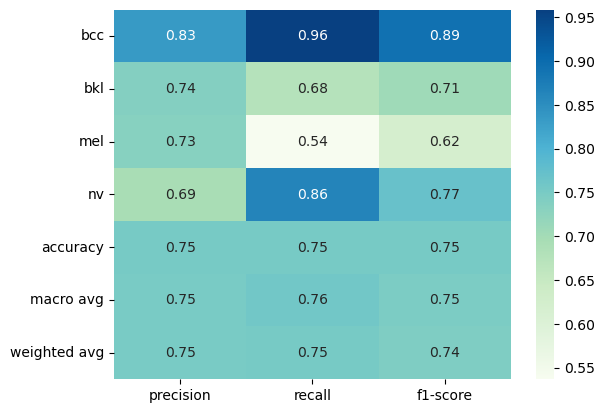

In [23]:
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, y_pred, target_names=["bcc","bkl","mel","nv"], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,  cmap="GnBu")

16/16 [==============================] - 0s 19ms/step


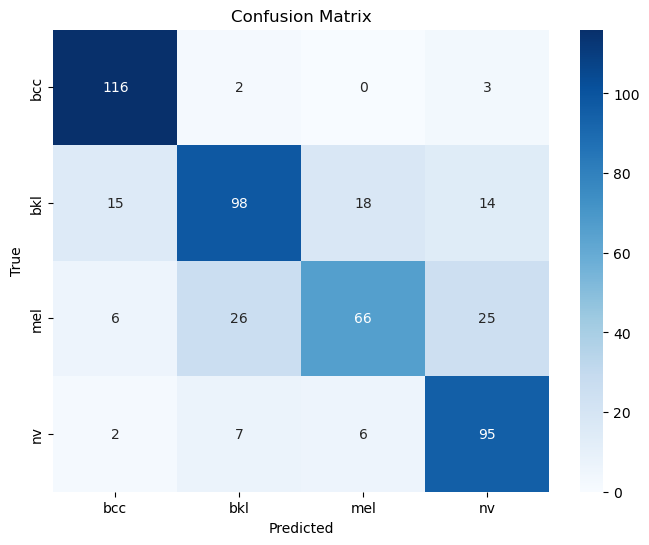

In [24]:


# After evaluating the model on the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = vit_classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Create confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


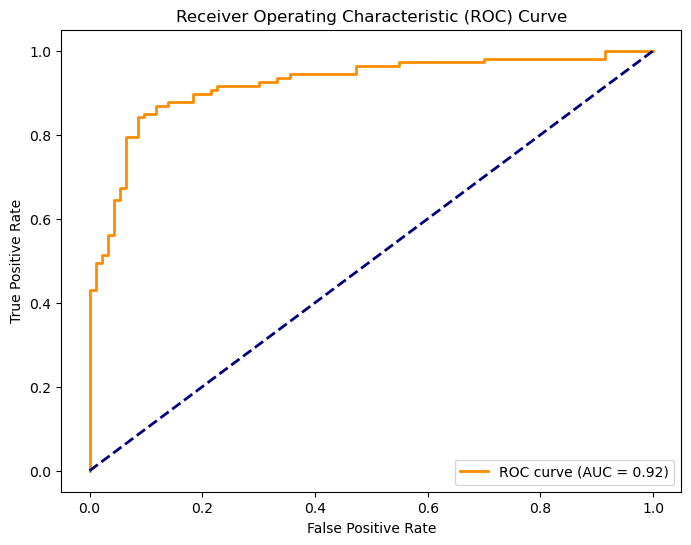

In [25]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Generate a synthetic dataset for demonstration
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and true labels from your VGG16 model
# Replace `y_pred` and `y_true` with your actual data
# For simplicity, I'm using a random example here

import numpy as np

# Generate random predictions and true labels for illustration
np.random.seed(42)
y_true = np.random.randint(2, size=100)  # Binary true labels (0 or 1)
y_pred = np.random.rand(100)  # Random continuous predictions

# Convert probabilities to binary predictions
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Calculate sensitivity and specificity
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity: 0.52
Specificity: 0.57
